In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 2: Download the Dataset from Google Drive
# You need to use the `gdown` package to download files from Google Drive
!pip install gdown

# Downloading the dataset from the shared link
dataset_url = 'https://drive.google.com/file/d/1onSVyGQXGEYLXNsVHh-Vn4tlej4-ZI8k/view?usp=drive_link'
!gdown $dataset_url -O /content/dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1onSVyGQXGEYLXNsVHh-Vn4tlej4-ZI8k
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1onSVyGQXGEYLXNsVHh-Vn4tlej4-ZI8k/view?usp=drive_link
To: /content/dataset.zip
92.1kB [00:00, 45.3MB/s]


In [ ]:
# Step 3: Unzip the Dataset
import zipfile
import os

# Unzipping the downloaded dataset
zip_path = '/content/drive/MyDrive/Capstone/Totalsegmentator_dataset_small_v201.zip'
unzip_dir = '/content/Totalsegmentator_dataset_small_v201'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

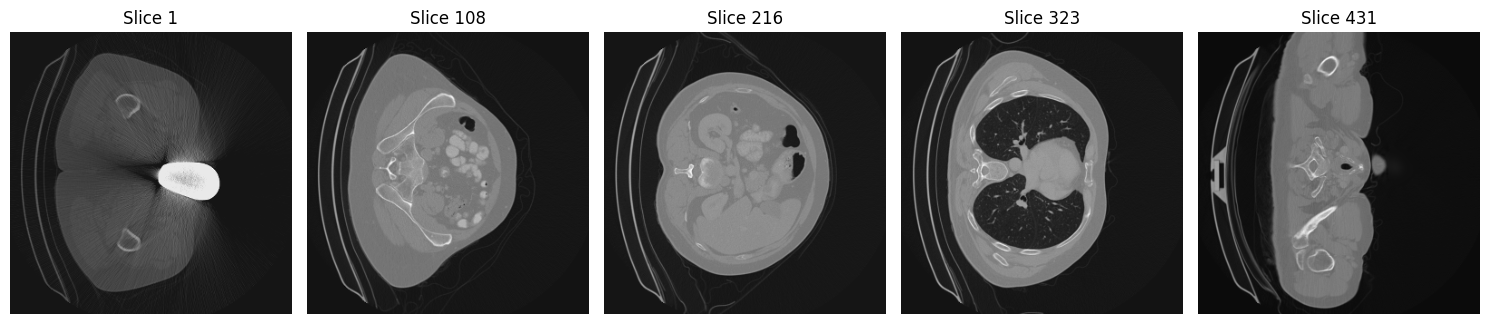

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Function to load and visualize a CT scan from a .nii.gz file
def visualize_ct_scan(ct_file_path, num_slices=5):
    # Load the CT scan using nibabel
    ct_scan = nib.load(ct_file_path).get_fdata()

    # Determine the middle slices to display
    slice_indices = np.linspace(0, ct_scan.shape[2] - 1, num_slices).astype(int)

    # Plot the selected slices
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(slice_indices):
        plt.subplot(1, num_slices, i + 1)
        plt.imshow(ct_scan[:, :, idx], cmap='gray')
        plt.title(f'Slice {idx + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Path to the CT scan file
sample_ct_file_path = '/content/Totalsegmentator_dataset_small_v201/s0011/ct.nii.gz'

# Visualize the CT scan
visualize_ct_scan(sample_ct_file_path, num_slices=5)

Visualizing: vertebrae_T1.nii.gz


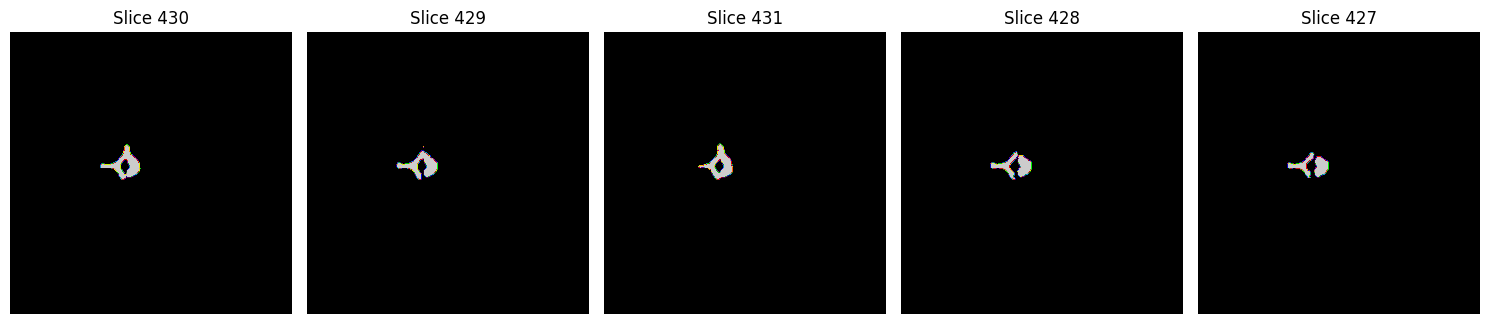

Visualizing: vertebrae_T10.nii.gz


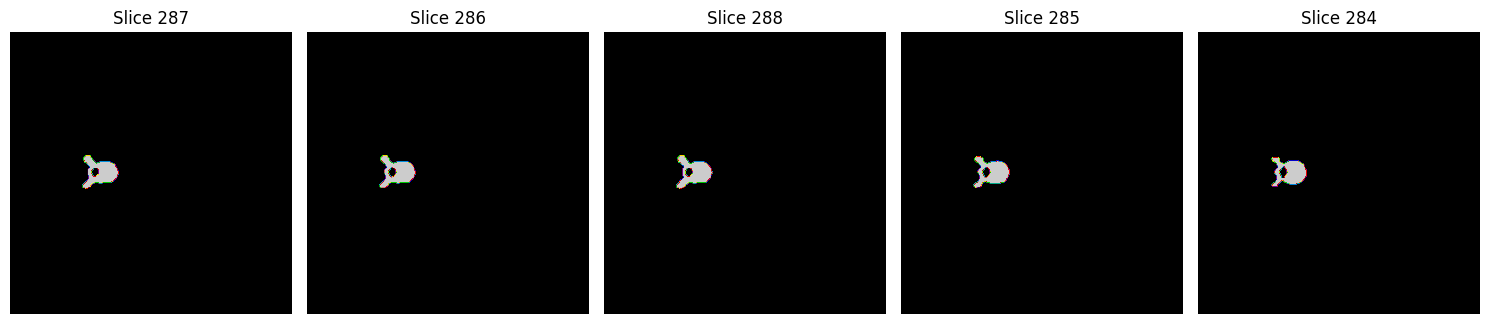

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to load and visualize segmentation from a .nii.gz file
def visualize_segmentation(seg_file_path, max_slices=5):
    # Load the segmentation file using nibabel
    segmentation = nib.load(seg_file_path).get_fdata()

    # Normalize the segmentation data to [0, 1] range for visualization
    segmentation = (segmentation - np.min(segmentation)) / (np.max(segmentation) - np.min(segmentation))

    # Find the slice indices that contain the most segmented data
    slice_scores = [np.sum(segmentation[:, :, idx]) for idx in range(segmentation.shape[2])]
    sorted_indices = np.argsort(slice_scores)[::-1]  # Sort slices by descending score

    # Pick the top slices with the most segmentation data
    top_indices = sorted_indices[:max_slices]

    # Plot the selected slices
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(top_indices):
        plt.subplot(1, len(top_indices), i + 1)
        plt.imshow(segmentation[:, :, idx], cmap='nipy_spectral')
        plt.title(f'Slice {idx + 1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Path to the segmentation folder
segmentation_folder_path = '/content/Totalsegmentator_dataset_small_v201/s0011/segmentations'

# List segmentation files available in the folder
segmentation_files = os.listdir(segmentation_folder_path)

# Display a few segmentations if available
if segmentation_files:
    for seg_file in segmentation_files[:2]:  # Display first 3 segmentation files as examples
        seg_file_path = os.path.join(segmentation_folder_path, seg_file)
        print(f"Visualizing: {seg_file}")
        visualize_segmentation(seg_file_path, max_slices=5)
else:
    print("No segmentation files found in the specified folder.")

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
import numpy as np
import os
from scipy.ndimage import zoom
import torch.nn as nn
import torch.optim as optim

# Custom Dataset for 3D Data
class CTScanDataset(Dataset):
    def __init__(self, data_frame, root_dir, target_size=(128, 128, 128)):
        self.data_frame = data_frame
        self.root_dir = root_dir
        self.target_size = target_size

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        file_info = self.data_frame.iloc[idx]
        image_id = file_info['image_id']

        # Paths to the CT scan
        ct_path = os.path.join(self.root_dir, image_id, 'ct.nii.gz')

        # Load the CT scan and resize
        ct_scan = self.load_nifti(ct_path)
        ct_scan = self.resize_3d(ct_scan, self.target_size)

        return torch.tensor(ct_scan, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

    def load_nifti(self, file_path):
        """Load a .nii.gz file and return as a numpy array."""
        nifti = nib.load(file_path)
        return np.array(nifti.get_fdata())

    def resize_3d(self, volume, target_size):
        """Resize a 3D numpy array to the target size."""
        factors = [t / s for s, t in zip(volume.shape, target_size)]
        resized_volume = zoom(volume, zoom=factors, order=1)  # Using linear interpolation
        return resized_volume

In [ ]:

# Paths
root_dir = '/content/Totalsegmentator_dataset_small_v201'  # Path to the unzipped dataset

# Load the dataset (only real CT scans, no segmentation needed for GAN)
train_df = pd.read_csv(os.path.join(root_dir, 'meta.csv'), delimiter=';')
train_dataset = CTScanDataset(train_df[train_df['split'] == 'train'], root_dir, target_size=(64, 64, 64))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

In [ ]:
# 3D GAN Generator
class Generator3D(nn.Module):
    def __init__(self, noise_dim=100, out_channels=1):
        super(Generator3D, self).__init__()
        self.noise_dim = noise_dim

        self.model = nn.Sequential(
            # Input is noise_dim x 1 x 1 x 1
            nn.ConvTranspose3d(noise_dim, 512, kernel_size=4, stride=1, padding=0),  # 4x4x4
            nn.BatchNorm3d(512),
            nn.ReLU(True),

            nn.ConvTranspose3d(512, 256, kernel_size=4, stride=2, padding=1),  # 8x8x8
            nn.BatchNorm3d(256),
            nn.ReLU(True),

            nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16x16
            nn.BatchNorm3d(128),
            nn.ReLU(True),

            nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32x32
            nn.BatchNorm3d(64),
            nn.ReLU(True),

            nn.ConvTranspose3d(64, out_channels, kernel_size=4, stride=2, padding=1),  # 64x64x64
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, x):
        x = x.view(x.size(0), self.noise_dim, 1, 1, 1)  # Reshape noise to 3D
        return self.model(x)

# 3D GAN Discriminator
class Discriminator3D(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator3D, self).__init__()
        self.model = nn.Sequential(
            # Input is 64x64x64 volume
            nn.Conv3d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # 32x32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16x16
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(128, 256, kernel_size=4, stride=2, padding=1),  # 8x8x8
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(256, 512, kernel_size=4, stride=2, padding=1),  # 4x4x4
            nn.BatchNorm3d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv3d(512, 1, kernel_size=4, stride=1, padding=0),  # 1x1x1
            nn.Sigmoid()  # Output single probability
        )

    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)

In [ ]:
# Initialize models
noise_dim = 100
generator = Generator3D(noise_dim=noise_dim)
discriminator = Discriminator3D()

# Optimizers
lr = 0.0002
beta1 = 0.5
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Loss function
criterion = nn.BCELoss()

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)

num_epochs = 10
real_label = 1.0
fake_label = 0.0

for epoch in range(num_epochs):
    for i, real_data in enumerate(train_loader):
        # Update Discriminator
        optimizer_D.zero_grad()

        # Real data
        real_data = real_data.to(device)
        b_size = real_data.size(0)
        labels = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = discriminator(real_data)
        loss_D_real = criterion(output, labels)
        loss_D_real.backward()

        # Fake data
        noise = torch.randn(b_size, noise_dim, device=device)
        fake_data = generator(noise)
        labels.fill_(fake_label)
        output = discriminator(fake_data.detach())
        loss_D_fake = criterion(output, labels)
        loss_D_fake.backward()
        optimizer_D.step()

        # Updating the Generator
        optimizer_G.zero_grad()
        labels.fill_(real_label)
        output = discriminator(fake_data)
        loss_G = criterion(output, labels)
        loss_G.backward()
        optimizer_G.step()

        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], '
                  f'Loss D: {loss_D_real.item() + loss_D_fake.item():.4f}, Loss G: {loss_G.item():.4f}')

# Save the generator model
torch.save(generator.state_dict(), '/content/3d_gan_generator.pth')
print("Generator model saved as'/content/3d_gan_generator.pth'")


Epoch [1/10], Step [0/25], Loss D: 1.3922, Loss G: 22.1049
Epoch [1/10], Step [10/25], Loss D: 1.3203, Loss G: 19.3367
Epoch [1/10], Step [20/25], Loss D: 0.0002, Loss G: 17.4595
Epoch [2/10], Step [0/25], Loss D: 4.4699, Loss G: 10.3090
Epoch [2/10], Step [10/25], Loss D: 0.4069, Loss G: 6.1272
Epoch [2/10], Step [20/25], Loss D: 0.1138, Loss G: 7.0179
Epoch [3/10], Step [0/25], Loss D: 0.2717, Loss G: 4.6352
Epoch [3/10], Step [10/25], Loss D: 0.4143, Loss G: 7.8280
Epoch [3/10], Step [20/25], Loss D: 1.9747, Loss G: 4.5623
Epoch [4/10], Step [0/25], Loss D: 0.3024, Loss G: 8.4120
Epoch [4/10], Step [10/25], Loss D: 1.7495, Loss G: 4.1639
Epoch [4/10], Step [20/25], Loss D: 0.1693, Loss G: 2.3737
Epoch [5/10], Step [0/25], Loss D: 1.8002, Loss G: 10.5375
Epoch [5/10], Step [10/25], Loss D: 1.8649, Loss G: 4.7032
Epoch [5/10], Step [20/25], Loss D: 0.5219, Loss G: 7.7436
Epoch [6/10], Step [0/25], Loss D: 0.0610, Loss G: 5.6957
Epoch [6/10], Step [10/25], Loss D: 0.0449, Loss G: 4.067

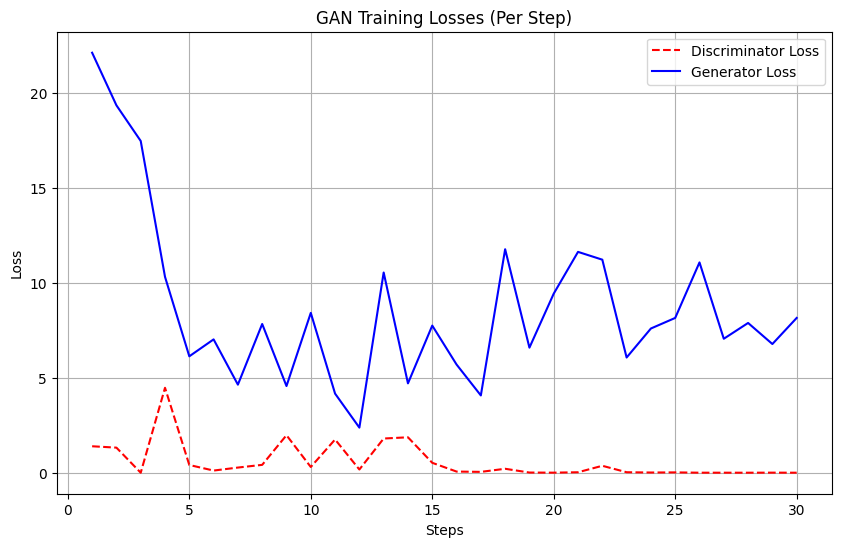

In [5]:
import matplotlib.pyplot as plt

# Discriminator and Generator losses
D_losses = [
    1.3922, 1.3203, 0.0002,
    4.4699, 0.4069, 0.1138,
    0.2717, 0.4143, 1.9747,
    0.3024, 1.7495, 0.1693,
    1.8002, 1.8649, 0.5219,
    0.0610, 0.0449, 0.2079,
    0.0094, 0.0032, 0.0249,
    0.3654, 0.0259, 0.0108,
    0.0171, 0.0017, 0.0013,
    0.0009, 0.0038, 0.0010
]

G_losses = [
    22.1049, 19.3367, 17.4595,
    10.3090, 6.1272, 7.0179,
    4.6352, 7.8280, 4.5623,
    8.4120, 4.1639, 2.3737,
    10.5375, 4.7032, 7.7436,
    5.6957, 4.0677, 11.7629,
    6.5829, 9.4257, 11.6232,
    11.2127, 6.0636, 7.5908,
    8.1467, 11.0690, 7.0506,
    7.8822, 6.7735, 8.1464
]

# steps
steps = list(range(1, len(D_losses) + 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, D_losses, label='Discriminator Loss', color='red', linestyle='--')
plt.plot(steps, G_losses, label='Generator Loss', color='blue', linestyle='-')

# Add labels, title, and legend
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('GAN Training Losses (Per Step)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from scipy import linalg
from torchvision.models.video import r3d_18
from torch.nn.functional import adaptive_avg_pool3d
from torch.utils.data import TensorDataset

# Load the saved generator model
class Generator3D(nn.Module):
    def __init__(self, noise_dim=100, out_channels=1):
        super(Generator3D, self).__init__()
        self.noise_dim = noise_dim

        self.model = nn.Sequential(
            nn.ConvTranspose3d(noise_dim, 512, kernel_size=4, stride=1, padding=0),  # 4x4x4
            nn.BatchNorm3d(512),
            nn.ReLU(True),
            nn.ConvTranspose3d(512, 256, kernel_size=4, stride=2, padding=1),  # 8x8x8
            nn.BatchNorm3d(256),
            nn.ReLU(True),
            nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16x16
            nn.BatchNorm3d(128),
            nn.ReLU(True),
            nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32x32
            nn.BatchNorm3d(64),
            nn.ReLU(True),
            nn.ConvTranspose3d(64, out_channels, kernel_size=4, stride=2, padding=1),  # 64x64x64
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, x):
        x = x.view(x.size(0), self.noise_dim, 1, 1, 1)  # Reshape noise to 3D
        return self.model(x)

# Load the pre-trained generator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
noise_dim = 100  # Use the same noise dimension as during training
generator = Generator3D(noise_dim=noise_dim)
generator.load_state_dict(torch.load('/content/3d_gan_generator.pth'))
generator = generator.to(device)
generator.eval()

# Load Pre-trained 3D Model for Feature Extraction (e.g., r3d_18 from torchvision)
feature_extractor = r3d_18(pretrained=True)
feature_extractor = feature_extractor.to(device)
feature_extractor.eval()

# Function to extract features using a pre-trained 3D ResNet
def extract_features(data_loader, model, device):
    features = []
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)
            outputs = model(data)
            outputs = adaptive_avg_pool3d(outputs, (1, 1, 1))  # Global average pooling to get feature vector
            features.append(outputs.view(outputs.size(0), -1).cpu().numpy())
    return np.concatenate(features, axis=0)

# Function to calculate FID score
def calculate_fid(real_features, fake_features):
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    # Compute FID score using the formula
    diff = mu_real - mu_fake
    try:
        # Adding a small epsilon for numerical stability
        covmean, _ = linalg.sqrtm(sigma_real.dot(sigma_fake) + np.eye(sigma_real.shape[0]) * 1e-10, disp=False)
    except Exception as e:
        print(f"Error calculating square root of the product of covariance matrices: {e}")
        return np.inf

    # Numerical stability check for complex numbers
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2.0 * covmean)
    return fid

# Function to calculate Inception Score
def inception_score(predictions, splits=10, eps=1e-16):
    scores = []
    N = predictions.shape[0]

    # Split predictions into groups
    split_size = N // splits
    for i in range(splits):
        part = predictions[i * split_size: (i + 1) * split_size]

        # Calculate KL divergence
        p_yx = np.clip(part, eps, 1.0)  # Clip probabilities to avoid log(0)
        p_y = np.clip(np.mean(p_yx, axis=0), eps, 1.0)

        kl_div = p_yx * (np.log(p_yx) - np.log(p_y))
        kl_div = np.mean(np.sum(kl_div, 1))
        scores.append(np.exp(kl_div))

    # Return mean and standard deviation
    return np.mean(scores), np.std(scores)

# Function to generate fake samples
def generate_fake_samples(generator, num_samples=10, noise_dim=100, target_size=(64, 64, 64)):
    generator.eval()
    fake_samples = []
    with torch.no_grad():
        for _ in range(num_samples):
            noise = torch.randn(1, noise_dim, device=device)
            fake_sample = generator(noise).cpu().numpy()
            fake_sample = fake_sample.reshape(-1, 1, *target_size)  # (batch_size, channels, D, H, W)
            fake_samples.append(fake_sample)
    return np.concatenate(fake_samples, axis=0)

# Load real samples from the dataset
def load_real_samples(data_loader):
    real_samples = []
    for data in data_loader:
        real_samples.append(data.cpu().numpy())
    return np.concatenate(real_samples, axis=0)

# Generate and evaluate the dataset
real_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
real_samples = load_real_samples(real_data_loader)
fake_samples = generate_fake_samples(generator, num_samples=100, noise_dim=noise_dim, target_size=(64, 64, 64))

# Create DataLoaders for feature extraction
real_loader = DataLoader(torch.tensor(real_samples), batch_size=8)
fake_loader = DataLoader(torch.tensor(fake_samples), batch_size=8)

# Extract features for real and fake samples
real_features = extract_features(real_loader, feature_extractor, device)
fake_features = extract_features(fake_loader, feature_extractor, device)

# Calculate FID
fid_score = calculate_fid(real_features, fake_features)
print(f"FID Score: {fid_score:.4f}")

# Calculate Inception Score
predictions = extract_features(fake_loader, feature_extractor, device)
is_mean, is_std = inception_score(predictions)
print(f"Inception Score: Mean = {is_mean:.4f}, Std = {is_std:.4f}")

3D-Unet Model


In [ ]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import zoom
import pandas as pd

# Custom Dataset for 3D Data
class CTScanDataset(Dataset):
    def __init__(self, base_dir, meta_file, target_size=(64, 64, 64), mode='train'):
        self.base_dir = base_dir
        self.target_size = target_size
        self.image_ids = self._get_image_ids(meta_file, mode)

    def _get_image_ids(self, meta_file, mode):
        meta_df = pd.read_csv(meta_file, delimiter=';')
        image_ids = meta_df[meta_df['split'] == mode]['image_id'].tolist()
        return image_ids

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        ct_path = os.path.join(self.base_dir, image_id, 'ct.nii.gz')
        mask_path = os.path.join(self.base_dir, image_id, 'segmentations')

        ct_scan = self.load_nifti(ct_path)
        combined_mask = np.zeros_like(ct_scan)

        for file_name in os.listdir(mask_path):
            if file_name.endswith('.nii.gz'):
                mask_path_full = os.path.join(mask_path, file_name)
                try:
                    mask = self.load_nifti(mask_path_full)
                    combined_mask = np.maximum(combined_mask, mask)
                except FileNotFoundError:
                    print(f"Warning: Segmentation file {file_name} not found for {image_id}, using a zero mask.")

        ct_scan = self.resize_3d(ct_scan, self.target_size)
        combined_mask = self.resize_3d(combined_mask, self.target_size)

        ct_scan_tensor = torch.tensor(ct_scan, dtype=torch.float32).unsqueeze(0)
        mask_tensor = torch.tensor(combined_mask, dtype=torch.float32).unsqueeze(0)

        return {'image': ct_scan_tensor, 'mask': mask_tensor}

    def load_nifti(self, file_path):
        nifti = nib.load(file_path)
        return np.array(nifti.get_fdata())

    def resize_3d(self, volume, target_size):
        factors = [t / s for s, t in zip(volume.shape, target_size)]
        resized_volume = zoom(volume, zoom=factors, order=1)
        return resized_volume

In [ ]:
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet3D, self).__init__()

        # Encoding path
        self.encoder1 = self.conv_block(in_channels, 32)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder2 = self.conv_block(32, 64)
        self.pool2 = nn.MaxPool3d(kernel_size=2, stride=2)

        self.encoder3 = self.conv_block(64, 128)

        # Decoding path
        self.upconv4 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.encoder4 = self.conv_block(64 + 64, 64)  # Concatenation with encoder2

        self.upconv5 = nn.ConvTranspose3d(64, 32, kernel_size=2, stride=2)
        self.encoder5 = self.conv_block(32 + 32, 32)  # Concatenation with encoder1

        # Output layer for reconstruction
        self.final_conv = nn.Conv3d(32, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)  # Output: [B, 32, D, H, W]
        pool1 = self.pool1(enc1)  # Output: [B, 32, D/2, H/2, W/2]

        enc2 = self.encoder2(pool1)  # Output: [B, 64, D/2, H/2, W/2]
        pool2 = self.pool2(enc2)  # Output: [B, 64, D/4, H/4, W/4]

        enc3 = self.encoder3(pool2)  # Output: [B, 128, D/4, H/4, W/4]

        # Decoding path
        up4 = self.upconv4(enc3)  # Output: [B, 64, D/2, H/2, W/2]
        merge4 = torch.cat((up4, enc2), dim=1)  # Concatenate with encoder2
        dec4 = self.encoder4(merge4)  # Output: [B, 64, D/2, H/2, W/2]

        up5 = self.upconv5(dec4)  # Output: [B, 32, D, H, W]
        merge5 = torch.cat((up5, enc1), dim=1)  # Concatenate with encoder1
        dec5 = self.encoder5(merge5)  # Output: [B, 32, D, H, W]

        return self.final_conv(dec5)  # Output: [B, out_channels, D, H, W]

In [ ]:
# Function to train the model
def train_model(model, train_loader, num_epochs=1, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs = data['image'].to(device)
            targets = data['mask'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}')

        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss / len(train_loader):.4f}')

# Load the dataset
root_dir = '/content/Totalsegmentator_dataset_small_v201'
meta_file = os.path.join(root_dir, 'meta.csv')

# Train Dataset
train_dataset = CTScanDataset(root_dir, meta_file, target_size=(64, 64, 64), mode='train')

# Check if the dataset is empty
if len(train_dataset) == 0:
    raise ValueError("No valid training samples found in the dataset.")

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialize and train the model
model = UNet3D(in_channels=1, out_channels=1)
train_model(model, train_loader, num_epochs=1, lr=0.001)

# Save the trained model
torch.save(model.state_dict(), '/content/3d_unet_model.pth')
print("3D U-Net model saved as '/content/3d_unet_model.pth'.")

Epoch [1/1], Step [0/98], Loss: 8.2869
Epoch [1/1], Step [10/98], Loss: 0.6767
Epoch [1/1], Step [20/98], Loss: 0.2894
Epoch [1/1], Step [30/98], Loss: 0.6454
Epoch [1/1], Step [40/98], Loss: 0.4554
Epoch [1/1], Step [50/98], Loss: 0.4287
Epoch [1/1], Step [60/98], Loss: 0.3062
Epoch [1/1], Step [70/98], Loss: 1.0159
Epoch [1/1], Step [80/98], Loss: 0.3408
Epoch [1/1], Step [90/98], Loss: 0.4869
Epoch [1/1], Average Loss: 0.5548
3D U-Net model saved as '/content/3d_unet_model.pth'.


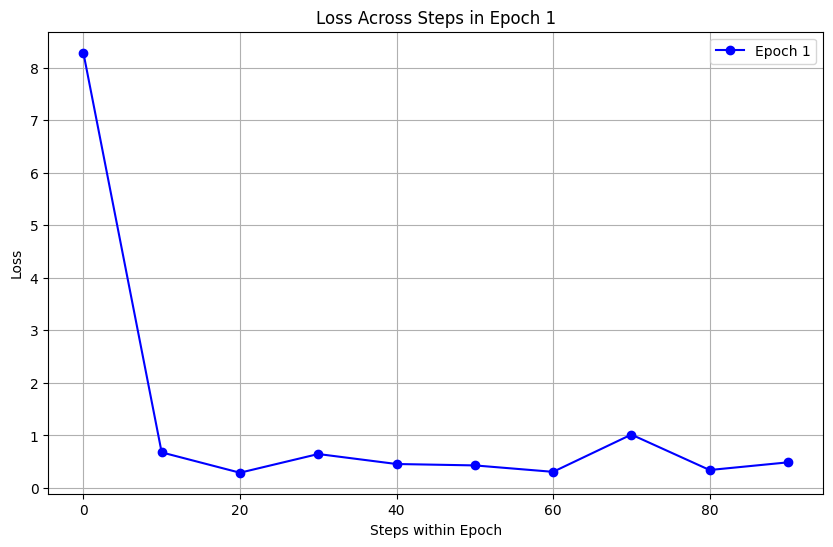

In [11]:
import matplotlib.pyplot as plt

# Loss values at each step
steps = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # Steps within epoch
losses = [8.2869, 0.6767, 0.2894, 0.6454, 0.4554, 0.4287, 0.3062, 1.0159, 0.3408, 0.4869]
epoch = 1

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, label=f"Epoch {epoch}", color="blue", marker="o", linestyle="-")

# Add labels, title, and legend
plt.xlabel("Steps within Epoch")
plt.ylabel("Loss")
plt.title(f"Loss Across Steps in Epoch {epoch}")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Testing Phase
test_dataset = CTScanDataset(root_dir, meta_file, target_size=(64, 64, 64), mode='val')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if the test dataset is empty
if len(test_dataset) == 0:
    raise ValueError("No valid test samples found in the dataset.")

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the model for testing
model.load_state_dict(torch.load('/content/3d_unet_model.pth'))
model.eval()

# Calculate accuracy on test set
total_dice = 0.0
num_samples = 0

with torch.no_grad():
    for data in test_loader:
        inputs = data['image'].to(device)
        targets = data['mask'].to(device)

        # Forward pass
        outputs = model(inputs)

        # Apply sigmoid to outputs and threshold to create binary predictions
        predictions = torch.sigmoid(outputs) > 0.5

        # Calculate Dice Coefficient
        intersection = (predictions * targets).sum()
        dice = (2.0 * intersection) / (predictions.sum() + targets.sum() + 1e-10)  # Avoid division by zero
        total_dice += dice.item()
        num_samples += 1

# Calculate and print the average Dice Coefficient
average_dice = total_dice / num_samples
print(f'Average Dice Coefficient on Test Set: {average_dice:.4f}')


<ipython-input-15-baba64612ae8>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/3d_unet_model.pth'))


Average Dice Coefficient on Test Set: 0.3783


DAE_Model


In [ ]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import zoom
import pandas as pd

# Custom Dataset for 3D Data
class CTScanDataset(Dataset):
    def __init__(self, base_dir, meta_file, target_size=(64, 64, 64), mode='train'):
        self.base_dir = base_dir
        self.target_size = target_size
        self.image_ids = self._get_image_ids(meta_file, mode)

    def _get_image_ids(self, meta_file, mode):
        meta_df = pd.read_csv(meta_file, delimiter=';')
        image_ids = meta_df[meta_df['split'] == mode]['image_id'].tolist()
        return image_ids

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        ct_path = os.path.join(self.base_dir, image_id, 'ct.nii.gz')
        mask_path = os.path.join(self.base_dir, image_id, 'segmentations')

        ct_scan = self.load_nifti(ct_path)
        combined_mask = np.zeros_like(ct_scan)

        for file_name in os.listdir(mask_path):
            if file_name.endswith('.nii.gz'):
                mask_path_full = os.path.join(mask_path, file_name)
                try:
                    mask = self.load_nifti(mask_path_full)
                    combined_mask = np.maximum(combined_mask, mask)
                except FileNotFoundError:
                    print(f"Warning: Segmentation file {file_name} not found for {image_id}, using a zero mask.")

        ct_scan = self.resize_3d(ct_scan, self.target_size)
        combined_mask = self.resize_3d(combined_mask, self.target_size)

        ct_scan_tensor = torch.tensor(ct_scan, dtype=torch.float32).unsqueeze(0)
        mask_tensor = torch.tensor(combined_mask, dtype=torch.float32).unsqueeze(0)

        return {'image': ct_scan_tensor, 'mask': mask_tensor}

    def load_nifti(self, file_path):
        nifti = nib.load(file_path)
        return np.array(nifti.get_fdata())

    def resize_3d(self, volume, target_size):
        factors = [t / s for s, t in zip(volume.shape, target_size)]
        resized_volume = zoom(volume, zoom=factors, order=1)
        return resized_volume

In [ ]:
# Autoencoder Model for 3D data
class Autoencoder3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(Autoencoder3D, self).__init__()

        # Encoder layers
        self.encoder1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=2, padding=1)
        self.encoder2 = nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1)
        self.encoder3 = nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1)

        # Decoder layers
        self.decoder1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.decoder3 = nn.ConvTranspose3d(64, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)

        # Activation functions
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoding path
        x = self.relu(self.encoder1(x))
        x = self.relu(self.encoder2(x))
        encoded = self.relu(self.encoder3(x))

        # Decoding path
        x = self.relu(self.decoder1(encoded))
        x = self.relu(self.decoder2(x))
        decoded = self.sigmoid(self.decoder3(x))

        return decoded

In [ ]:
# Function to train the autoencoder model
def train_autoencoder(model, train_loader, num_epochs=1, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs = data['image'].to(device)
            targets = data['mask'].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}')

        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss / len(train_loader):.4f}')

# Load the dataset paths
root_dir = '/content/Totalsegmentator_dataset_small_v201'
meta_file = os.path.join(root_dir, 'meta.csv')

# Training Dataset
train_dataset = CTScanDataset(root_dir, meta_file, target_size=(64, 64, 64), mode='train')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Initialize and train the autoencoder
autoencoder = Autoencoder3D(in_channels=1, out_channels=1)
train_autoencoder(autoencoder, train_loader, num_epochs=1, lr=0.001)

# Save the trained model
torch.save(autoencoder.state_dict(), '/content/3d_autoencoder_model.pth')
print("3D Autoencoder model saved as '/content/3d_autoencoder_model.pth'.")

Epoch [1/1], Step [0/98], Loss: 0.3471
Epoch [1/1], Step [10/98], Loss: 0.0527
Epoch [1/1], Step [20/98], Loss: 0.0573
Epoch [1/1], Step [30/98], Loss: 0.0770
Epoch [1/1], Step [40/98], Loss: 0.0743
Epoch [1/1], Step [50/98], Loss: 0.1081
Epoch [1/1], Step [60/98], Loss: 0.0621
Epoch [1/1], Step [70/98], Loss: 0.0411
Epoch [1/1], Step [80/98], Loss: 0.0597
Epoch [1/1], Step [90/98], Loss: 0.0415
Epoch [1/1], Average Loss: 0.0963
3D Autoencoder model saved as '/content/3d_autoencoder_model.pth'.


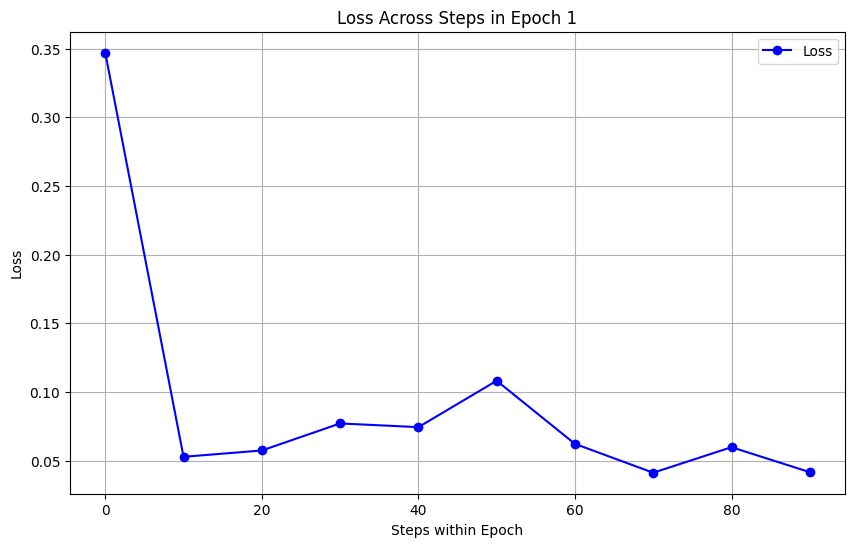

In [12]:
import matplotlib.pyplot as plt

# Loss values at each step
steps = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # Steps within the epoch
losses = [0.3471, 0.0527, 0.0573, 0.0770, 0.0743, 0.1081, 0.0621, 0.0411, 0.0597, 0.0415]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, label="Loss", color="blue", marker="o", linestyle="-")

# Add labels, title, and legend
plt.xlabel("Steps within Epoch")
plt.ylabel("Loss")
plt.title("Loss Across Steps in Epoch 1")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
# Specify device for testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model for testing
autoencoder.load_state_dict(torch.load('/content/3d_autoencoder_model.pth', weights_only=True))
autoencoder.to(device)  # Move model to the device
autoencoder.eval()

# Test dataset and DataLoader
test_dataset = CTScanDataset(root_dir, meta_file, target_size=(64, 64, 64), mode='val')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Calculate accuracy on test set using Dice Coefficient
total_dice = 0.0
num_samples = 0

with torch.no_grad():
    for data in test_loader:
        inputs = data['image'].to(device)
        targets = data['mask'].to(device)

        # Forward pass
        outputs = autoencoder(inputs)

        # Apply threshold to create binary predictions
        predictions = outputs > 0.5

        # Calculate Dice Coefficient
        intersection = (predictions * targets).sum()
        dice = (2.0 * intersection) / (predictions.sum() + targets.sum() + 1e-10)  # Avoid division by zero
        total_dice += dice.item()
        num_samples += 1

# Calculate and print the average Dice Coefficient
average_dice = total_dice / num_samples
print(f'Average Dice Coefficient on Test Set: {average_dice:.4f}')


Average Dice Coefficient on Test Set: 0.3742
